In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Golden Retriever Dog Emotions.zip to Golden Retriever Dog Emotions.zip


In [ ]:
import zipfile
import os

zip_filename = next(iter(uploaded))  # gets the uploaded file name
extract_path = '/content/dog_emotions'  # Changed to a directory name

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_paths=[]
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
              image_paths.append(os.path.join(root, file))

In [ ]:
from collections import defaultdict
from pathlib import Path

label_to_images = defaultdict(list)
for path in image_paths:
    label = Path(path).parent.name
    label_to_images[label].append(path)


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

split_dir = '/content/dog_emotions_split'
os.makedirs(split_dir, exist_ok=True)

def copy_files(image_list, dest_dir):
    for path in image_list:
        label = Path(path).parent.name
        label_folder = os.path.join(dest_dir, label)
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy2(path, os.path.join(label_folder, Path(path).name))

for label, paths in label_to_images.items():
    train_imgs, test_imgs = train_test_split(paths, train_size=0.8, random_state=42)
    copy_files(train_imgs, os.path.join(split_dir, 'train'))
    copy_files(test_imgs, os.path.join(split_dir, 'test'))


In [ ]:
shutil.make_archive('/content/dog_emotions_split', 'zip', split_dir)

'/content/dog_emotions_split.zip'

In [ ]:
import tensorflow as tf

# Define dataset paths
train_dir = "/content/dog_emotions_split/train"
test_dir = "/content/dog_emotions_split/test"

# Load datasets
batch_size = 32
img_size = (224, 224)  # Resize to match common models like ResNet, MobileNet

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)


Found 720 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


In [ ]:
# Normalize pixel values (0 to 1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 720 files belonging to 3 classes.


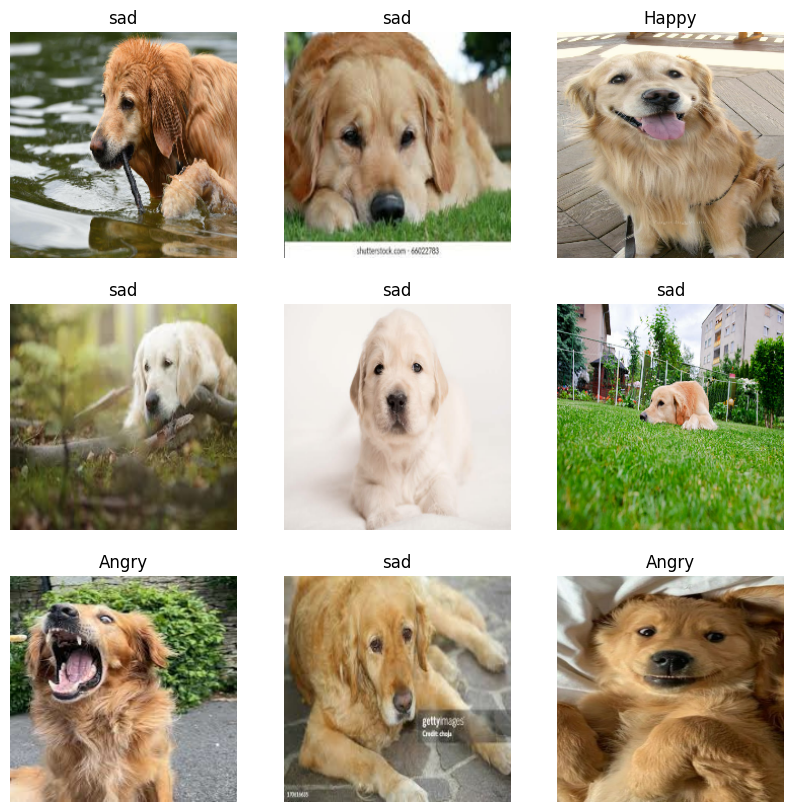

In [ ]:
import matplotlib.pyplot as plt

# Retrieve class names before applying .map()
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/dog_emotions_split/train",
    image_size=(224, 224),
    batch_size=32
)

class_names = train_dataset_raw.class_names  # Save class names

# Visualize images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset_raw.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to NumPy
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 without top layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False # Freeze base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduce feature map size
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(len(class_names), activation="softmax") # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# CNN

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4550 - loss: 1.5531

23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4588 - loss: 1.5417 - val_accuracy: 0.5833 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7743 - loss: 0.5969

23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7744 - loss: 0.5972 - val_accuracy: 0.6889 - val_loss: 0.6902 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8330 - loss: 0.5228

23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8334 - loss: 0.5214 - val_accuracy: 0.7333 - val_loss: 0.5964 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8543 - loss: 0.4067

23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8537 - loss: 0.4073 - val_accuracy: 0.7444 - val_loss: 0.5667 - learning_rate: 1.0000e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8798 - loss: 0.3973

23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8803 - loss: 0.3949 - val_accuracy: 0.7833 - val_loss: 0.5204 - learning_rate: 1.0000e-04
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8832 - loss: 0.2970

23/23 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8828 - loss: 0.2992 - val_accuracy: 0.7944 - val_loss: 0.4977 - learning_rate: 1.0000e-04
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.9002 - loss: 0.2884 - val_accuracy: 0.7889 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9131 - loss: 0.2211 - val_accuracy: 0.7944 - val_loss: 0.5220 - learning_rate: 1.0000e-04
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9241 - loss: 0.1707 - val_accuracy: 0.7944 - val_loss: 0.5902 - learning_rate: 5.0000e-05
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9157 - loss: 0.2030

23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9157 - loss: 0.2031 - val_accuracy: 0.8278 - val_loss: 0.5008 - learning_rate: 5.0000e-05
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
✅ Final Train Accuracy: 91.39%
✅ Final Validation Accuracy: 82.78%
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7605 - loss: 0.6524

✅ Test Accuracy: 82.78%

🧾 Classification Report:
              precision    recall  f1-score   support

       Angry     0.9070    0.6500    0.7573        60
       Happy     0.7500    0.9000    0.8182        60
         sad     0.8615    0.9333    0.8960        60

    accuracy                         0.8278       180
   macro avg     0.8395    0.8278    0.8238       180
weighted avg     0.8395    0.8278    0.8238       180



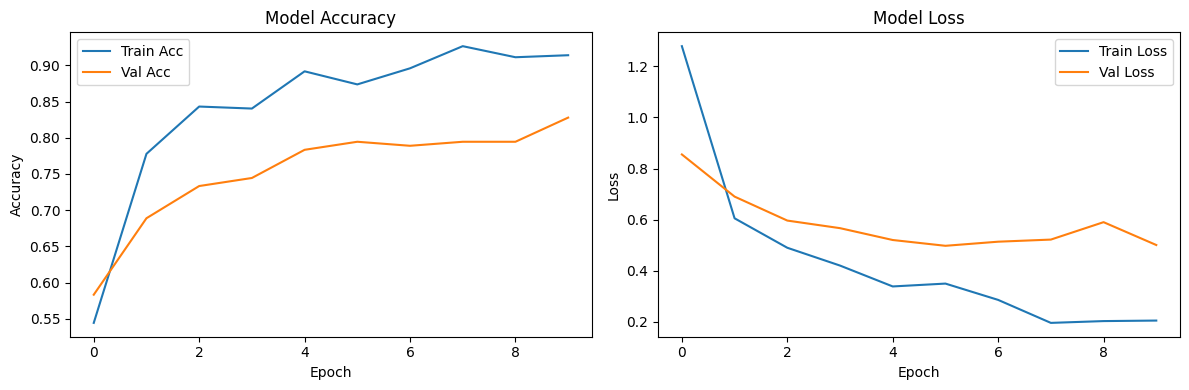

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Paths
train_dir = "/content/dog_emotions_split/train"
test_dir = "/content/dog_emotions_split/test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label alignment
)

# Number of classes
num_classes = train_dataset.num_classes

# Build Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = True

# Fine-tuning: freeze all except last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
mc = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Train
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[lr, es, mc]
)

# Load best model
model.load_weights("best_model.h5")

# Evaluate
y_true = test_dataset.classes
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
labels = list(test_dataset.class_indices.keys())

final_train_acc = history.history["accuracy"][-1] * 100
final_val_acc = history.history["val_accuracy"][-1] * 100

print(f"✅ Final Train Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")

# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# Classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels,digits=4))

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
total_samples = 720 + 180  # Train + Validation
weighted_acc = ((720 * final_train_acc) + (180 * final_val_acc)) / total_samples

print(f"🌍 Overall Model Accuracy: {weighted_acc:.2f}%")

🌍 Overall Model Accuracy: 89.67%


# CNN+LSTM

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4979 - loss: 1.0590 - val_accuracy: 0.7222 - val_loss: 0.8722 - learning_rate: 5.0000e-04
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7527 - loss: 0.7917 - val_accuracy: 0.7556 - val_loss: 0.5749 - learning_rate: 5.0000e-04
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8098 - loss: 0.4987 - val_accuracy: 0.7944 - val_loss: 0.5322 - learning_rate: 5.0000e-04
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9131 - loss: 0.2780 - val_accuracy: 0.8167 - val_loss: 0.4832 - learning_rate: 5.0000e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8413 - loss: 0.3961 - val_accuracy: 0.8444 - val_loss: 0.5064 - learning_rate: 5.0000e-04
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8824 - loss: 0.3146 - val_accuracy: 0.8333 - val_loss: 0.4550 - learning_rate: 5.0000e-04
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8858 - loss:

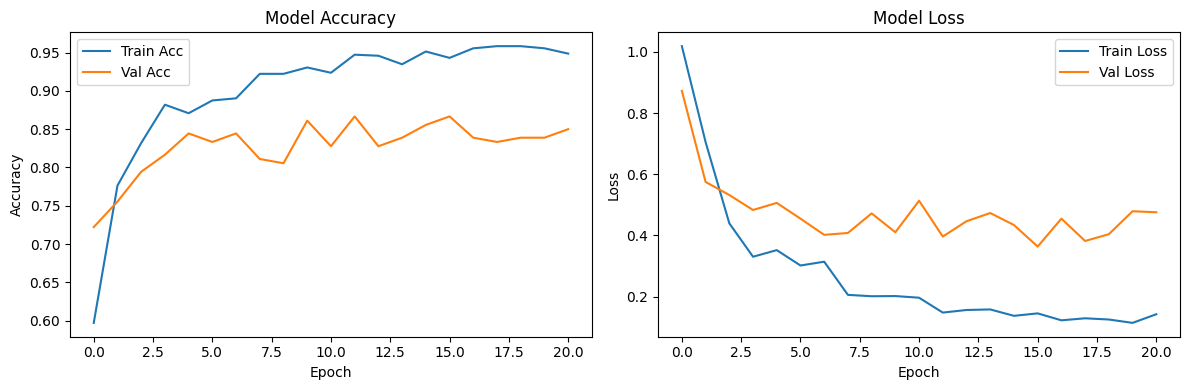

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load Pretrained CNN (MobileNetV2) for Feature Extraction
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),  # Reshape for LSTM input
        # LSTM layers
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Regularization
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Load and preprocess dataset with Data Augmentation
def preprocess_dataset(directory, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    dataset = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return dataset

train_dir = '/content/dog_emotions_split/train'
test_dir = '/content/dog_emotions_split/test'

train_dataset = preprocess_dataset(train_dir)
test_dataset = preprocess_dataset(test_dir)

input_shape = (224, 224, 3)  # Image size
num_classes = 3  # Angry, Happy, Sad

# Build CNN+LSTM model
cnn_lstm_model = build_cnn_lstm_model(input_shape, num_classes)
cnn_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR for fine-tuning
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train model with Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_lstm_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate model
test_loss, test_acc = cnn_lstm_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
# Final Training Accuracy
final_train_acc = history.history["accuracy"][-1] * 100
print(f"Train Accuracy: {final_train_acc:.2f}%")
final_val_acc = history.history["val_accuracy"][-1] * 100
print(f" Validation Accuracy: {final_val_acc:.2f}%")
# Classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels,digits=4))

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


🔁 Fold 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.4304 - loss: 1.0793 - val_accuracy: 0.7639 - val_loss: 0.9792 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7765 - loss: 0.8741 - val_accuracy: 0.7708 - val_loss: 0.6781 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8673 - loss: 0.5158 - val_accuracy: 0.8264 - val_loss: 0.4828 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9047 - loss: 0.2968 - val_accuracy: 0.8542 - val_loss: 0.4484 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9319 - loss: 0.1891 - val_accuracy: 0.8611 - val_loss: 0.4384 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9715 - loss: 0.1095 - val_accuracy: 0.8472 - val_loss: 0.4927 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.99

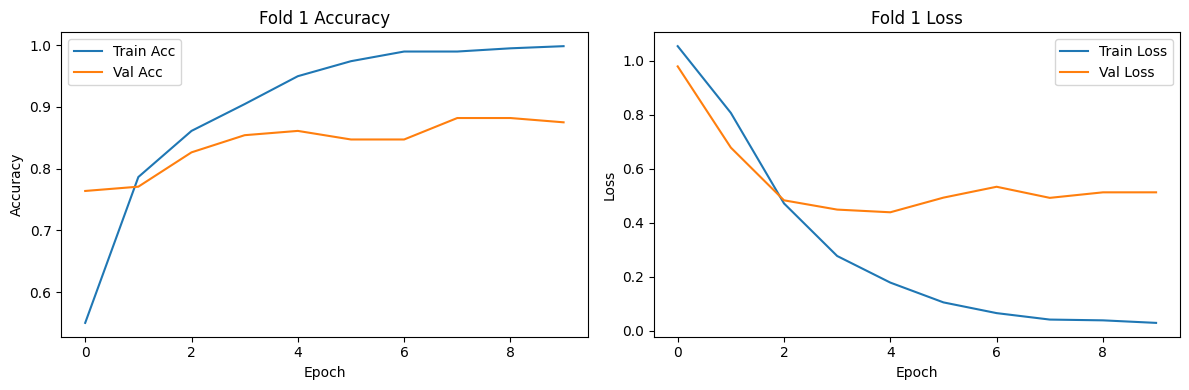


🔁 Fold 2
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5380 - loss: 1.0682 - val_accuracy: 0.7847 - val_loss: 0.9274 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7995 - loss: 0.8499 - val_accuracy: 0.7778 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8571 - loss: 0.4952 - val_accuracy: 0.8681 - val_loss: 0.4144 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9024 - loss: 0.2652 - val_accuracy: 0.8750 - val_loss: 0.3514 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9383 - loss: 0.1918 - val_accuracy: 0.8542 - val_loss: 0.4485 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9761 - loss: 0.1086 - val_accuracy: 0.8681 - val_loss: 0.4046 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.98

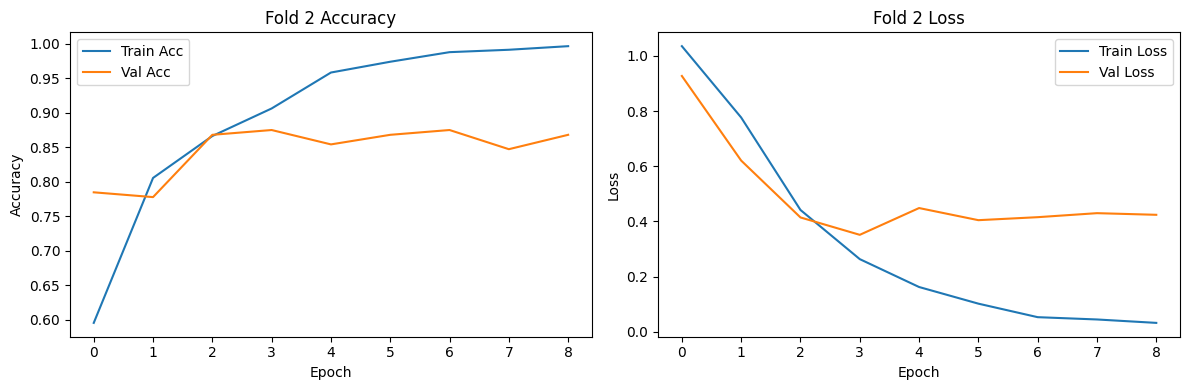


🔁 Fold 3
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4475 - loss: 1.0773 - val_accuracy: 0.7431 - val_loss: 0.9500 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7524 - loss: 0.8655 - val_accuracy: 0.8056 - val_loss: 0.5975 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8612 - loss: 0.5175 - val_accuracy: 0.8333 - val_loss: 0.3863 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9285 - loss: 0.2609 - val_accuracy: 0.8681 - val_loss: 0.3137 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9352 - loss: 0.1944 - val_accuracy: 0.8750 - val_loss: 0.2954 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9825 - loss: 0.0815 - val_accuracy: 0.8750 - val_loss: 0.3193 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.98

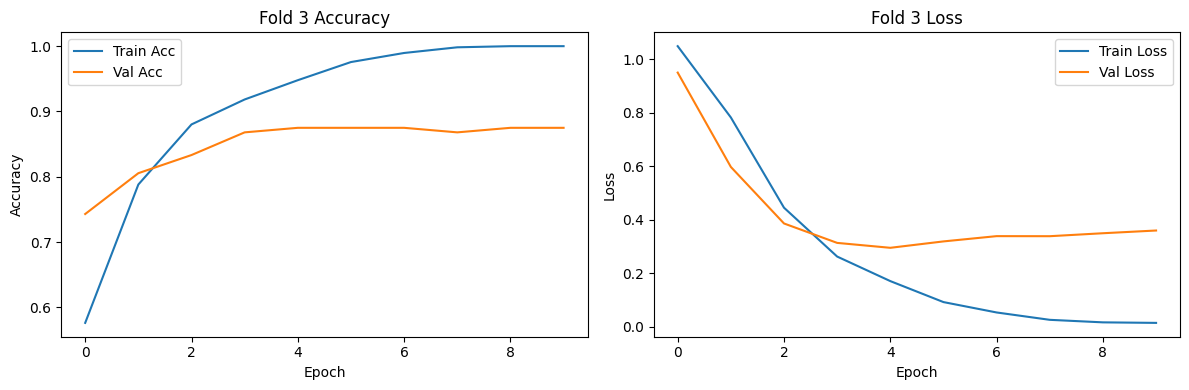


🔁 Fold 4
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5063 - loss: 1.0739 - val_accuracy: 0.7292 - val_loss: 0.9685 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7305 - loss: 0.8935 - val_accuracy: 0.7778 - val_loss: 0.6806 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8477 - loss: 0.5605 - val_accuracy: 0.8194 - val_loss: 0.4691 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9003 - loss: 0.3182 - val_accuracy: 0.8333 - val_loss: 0.4050 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9508 - loss: 0.1729 - val_accuracy: 0.8403 - val_loss: 0.4641 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9642 - loss: 0.1291 - val_accuracy: 0.8403 - val_loss: 0.4121 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.99

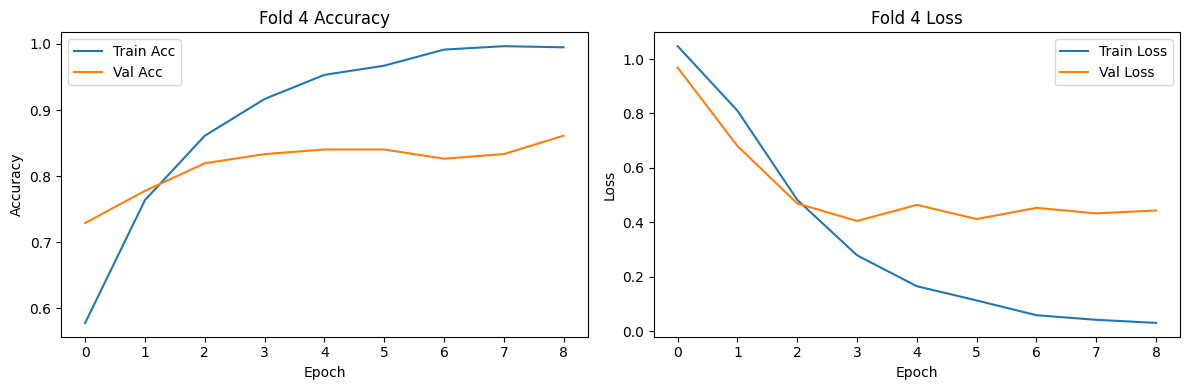


🔁 Fold 5
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5186 - loss: 1.0709 - val_accuracy: 0.7569 - val_loss: 0.9433 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7676 - loss: 0.8612 - val_accuracy: 0.8056 - val_loss: 0.6079 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8815 - loss: 0.4885 - val_accuracy: 0.8611 - val_loss: 0.3723 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9196 - loss: 0.2583 - val_accuracy: 0.8958 - val_loss: 0.3341 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9622 - loss: 0.1648 - val_accuracy: 0.8542 - val_loss: 0.3842 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9651 - loss: 0.1280 - val_accuracy: 0.8681 - val_loss: 0.3689 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.97

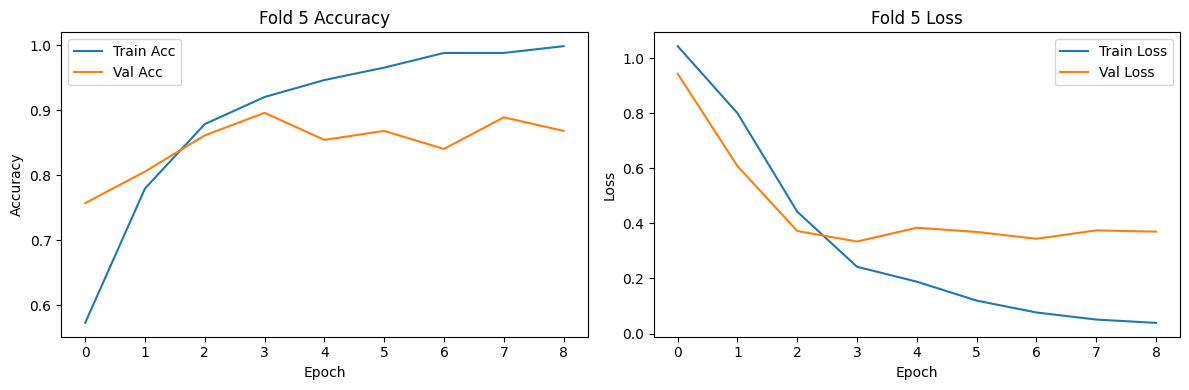


📊 Average Accuracy over 5 folds: 86.81%

🧾 5-Fold Averaged Classification Report:
              precision     recall   f1-score    support
Angry            0.8459     0.8375     0.8390         48
Happy            0.8543     0.9042     0.8764         48
sad              0.9181     0.8625     0.8885         48
                                                        
accuracy         0.8681     0.8681     0.8681        144
macro avg        0.8728     0.8681     0.8679        144
weighted avg     0.8728     0.8681     0.8679        144


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt

# Configuration
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 30
train_dir = '/content/dog_emotions_split/train'

# Load all images and labels
def load_dataset(directory):
    X = []
    y = []
    class_labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_path = os.path.join(directory, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=input_shape[:2])
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label_map[label])
            except:
                continue
    return np.array(X), np.array(y), class_labels

X, y, labels = load_dataset(train_dir)

# Build model
def build_cnn_lstm_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_fold_accuracies = []
all_reports = [] # Initialize all_reports here

for train_idx, val_idx in skf.split(X, y):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Create the model
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = np.mean(y_pred_classes == y_val) * 100
    all_fold_accuracies.append(acc)
    print(f"\n✅ Fold {fold} Accuracy: {acc:.2f}%")
    print("\n🧾 Classification Report:")
    report = classification_report(y_val, y_pred_classes, target_names=labels, digits=4, output_dict=True)
    all_reports.append(report)
    # Still print per-fold report
    print(classification_report(y_val, y_pred_classes, target_names=labels, digits=4))
    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    fold += 1

# Summary
print(f"\n📊 Average Accuracy over 5 folds: {np.mean(all_fold_accuracies):.2f}%")

# Average all classification reports
avg_report = {}
keys = all_reports[0].keys()

for key in keys:
    if isinstance(all_reports[0][key], dict):
        avg_report[key] = {}
        for metric in all_reports[0][key]:
            avg_report[key][metric] = np.mean([r[key][metric] for r in all_reports])
    else:
        avg_report[key] = np.mean([r[key] for r in all_reports])

# Final averaged report printout
print("\n🧾 5-Fold Averaged Classification Report:")
print("{:<12} {:>10} {:>10} {:>10} {:>10}".format("", "precision", "recall", "f1-score", "support"))

for label in labels:
    pr = avg_report[label]
    print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
        label, pr["precision"], pr["recall"], pr["f1-score"], pr["support"]
    ))

print("{:<12} {:>10} {:>10} {:>10} {:>10}".format("", "", "", "", ""))
# Handle accuracy separately as it's a float, not a dictionary
if "accuracy" in avg_report:
    print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
        "accuracy", avg_report["accuracy"], avg_report["accuracy"], avg_report["accuracy"],
        sum(avg_report[label]["support"] for label in labels)
    ))


for avg_type in ["macro avg", "weighted avg"]:
    if avg_type in avg_report and isinstance(avg_report[avg_type], dict):
      pr = avg_report[avg_type]
      print("{:<12} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.0f}".format(
          avg_type, pr["precision"], pr["recall"], pr["f1-score"], pr["support"]
      ))

In [ ]:
total_samples = 720 + 180  # Train + Validation
weighted_acc = ((720 * final_train_acc) + (180 * final_val_acc)) / total_samples

print(f"🌍 Overall Model Accuracy: {weighted_acc:.2f}%")

🌍 Overall Model Accuracy: 88.22%


# CNN+RNN

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4377 - loss: 1.0642 - val_accuracy: 0.7444 - val_loss: 0.7653 - learning_rate: 5.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7136 - loss: 0.7029 - val_accuracy: 0.7667 - val_loss: 0.5511 - learning_rate: 5.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7871 - loss: 0.5288 - val_accuracy: 0.8056 - val_loss: 0.4670 - learning_rate: 5.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8333 - loss: 0.4346 - val_accuracy: 0.8111 - val_loss: 0.5356 - learning_rate: 5.0000e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8932 - loss: 0.3263 - val_accuracy: 0.7833 - val_loss: 0.5710 - learning_rate: 5.0000e-04
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8465 - loss: 0.3989 - val_accuracy: 0.8111 - val_loss: 0.5013 - learning_rate: 2.5000e-04
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8848 - loss:

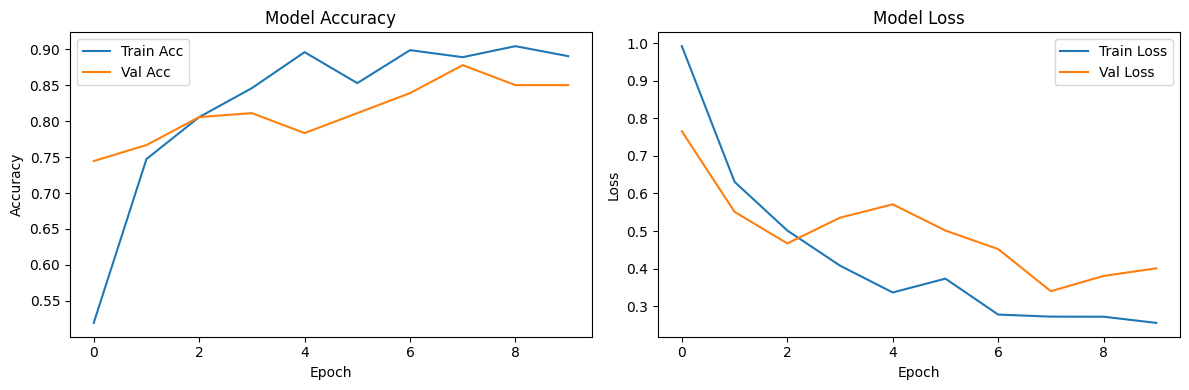

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load Pretrained CNN (MobileNetV2) for Feature Extraction
def build_cnn_rnn_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Reshape((1, -1)),  # Reshape for RNN input
        # Simple RNN layer
        layers.SimpleRNN(128, activation='relu', return_sequences=True),
        layers.SimpleRNN(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Regularization
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Load and preprocess dataset with Data Augmentation
def preprocess_dataset(directory, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    dataset = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return dataset

train_dir = '/content/dog_emotions_split/train'
test_dir = '/content/dog_emotions_split/test'

train_dataset = preprocess_dataset(train_dir)
test_dataset = preprocess_dataset(test_dir)

input_shape = (224, 224, 3)  # Image size
num_classes = 3  # Angry, Happy, Sad

# Build CNN+RNN model
cnn_rnn_model = build_cnn_rnn_model(input_shape, num_classes)
cnn_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR for fine-tuning
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train model with Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_rnn_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate model
test_loss, test_acc = cnn_rnn_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
# Final Training Accuracy
final_train_acc = history.history["accuracy"][-1] * 100
print(f"Train Accuracy: {final_train_acc:.2f}%")
final_val_acc = history.history["val_accuracy"][-1] * 100
print(f" Validation Accuracy: {final_val_acc:.2f}%")
# Classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels,digits=4))

# Accuracy & Loss Plots
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
total_samples = 720 + 180  # Train + Validation
weighted_acc = ((720 * final_train_acc) + (180 * final_val_acc)) / total_samples

print(f"🌍 Overall Model Accuracy: {weighted_acc:.2f}%")

🌍 Overall Model Accuracy: 90.56%


# MobileNetV2

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4732 - loss: 1.1033 - val_accuracy: 0.7278 - val_loss: 0.6985 - learning_rate: 5.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7522 - loss: 0.6215 - val_accuracy: 0.7778 - val_loss: 0.5579 - learning_rate: 5.0000e-04
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8168 - loss: 0.4455 - val_accuracy: 0.8111 - val_loss: 0.4718 - learning_rate: 5.0000e-04
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8486 - loss: 0.4155 - val_accuracy: 0.7778 - val_loss: 0.5094 - learning_rate: 5.0000e-04
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8711 - loss: 0.3702 - val_accuracy: 0.8111 - val_loss: 0.4491 - learning_rate: 5.0000e-04
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8580 - loss: 0.3590 - val_accuracy: 0.8111 - val_loss: 0.4749 - learning_rate: 5.0000e-04
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8878 - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

🧾 Classification Report:
              precision    recall  f1-score   support

       Angry     0.8182    0.7500    0.7826        60
       Happy     0.7619    0.8000    0.7805        60
         sad     0.8871    0.9167    0.9016        60

    accuracy                         0.8222       180
   macro avg     0.8224    0.8222    0.8216       180
weighted avg     0.8224    0.8222    0.8216       180



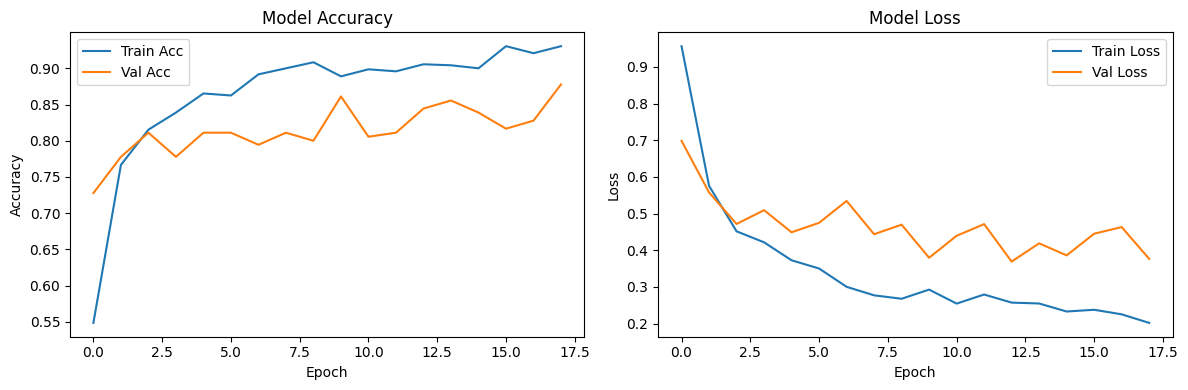

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to load and preprocess dataset
def preprocess_dataset(directory, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    dataset = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return dataset

# Paths
train_dir = '/content/dog_emotions_split/train'
test_dir = '/content/dog_emotions_split/test'

# Load datasets
train_dataset = preprocess_dataset(train_dir)
test_dataset = preprocess_dataset(test_dir)

input_shape = (224, 224, 3)
num_classes = 3

# Build MobileNetV2-based model
def build_mobilenet_model(input_shape, num_classes):
    base_model = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze pretrained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile model
mobilenet_model = build_mobilenet_model(input_shape, num_classes)
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mobilenet_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=25,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
test_loss, test_acc = mobilenet_model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# Final training accuracy
final_train_acc = history.history["accuracy"][-1] * 100
print(f"Train Accuracy: {final_train_acc:.2f}%")
final_val_acc = history.history["val_accuracy"][-1] * 100
print(f"Validation Accuracy: {final_val_acc:.2f}%")

# Classification report
y_true, y_pred = [], []
labels = list(test_dataset.class_indices.keys())
test_dataset.reset()

for i in range(len(test_dataset)):
    x, y = test_dataset[i]
    y_true.extend(np.argmax(y, axis=1))
    preds = mobilenet_model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
total_samples = 720 + 180  # Train + Validation
weighted_acc = ((720 * final_train_acc) + (180 * final_val_acc)) / total_samples

print(f"🌍 Overall Model Accuracy: {weighted_acc:.2f}%")

🌍 Overall Model Accuracy: 92.00%
